In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats.mstats import winsorize
import pandas_profiling 
%matplotlib inline

In [2]:
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, accuracy_score, classification_report

from sklearn.linear_model import LinearRegression

Create UDFs

In [3]:
# Create Data audit Report for continuous variables
def continuous_var_summary( x ):
    
    n_tot = x.isnull().count()
    n_miss = x.isnull().sum()
    n_miss_perc = n_miss / n_tot
    
    p25 = x.quantile(0.25)
    p75 = x.quantile(0.75)
    
    iqr = p75 - p25
    
    lc_iqr = p25 - 1.5 * iqr
    uc_iqr = p75 + 1.5 * iqr
    
    return pd.Series( [ x.dtype, x.nunique(), n_tot, x.count(), n_miss, n_miss_perc, 
                       x.sum(), x.var(), x.std(), x.mean(), 
                       iqr, lc_iqr, uc_iqr, 
                       x.min(), x.quantile(0.01), x.quantile(0.05), x.quantile(0.10), 
                       x.quantile(0.25), x.quantile(0.50), x.quantile(0.75), 
                       x.quantile(0.90), x.quantile(0.95), x.quantile(0.99), x.max()],
                     
                    index = ['dtype', 'cardinality', 'n_tot', 'n', 'n_miss', 'n_miss_perc',
                             'sum', 'var', 'std', 'mean',
                             'iqr', 'lc_iqr', 'uc_iqr',
                             'min', 'p1', 'p5', 'p10', 
                             'p25', 'p50', 'p75', 
                             'p90', 'p95', 'p99', 'max'])

In [4]:
# Create Data audit Report for categorical variables
def categorical_var_summary( x ):
    Mode = x.value_counts().sort_values(ascending = False)[0:1].reset_index()
    return pd.Series([x.count(), x.isnull().sum(),x.nunique(), Mode.iloc[0, 0], Mode.iloc[0, 1], 
                          round(Mode.iloc[0, 1] * 100/x.count(), 2)], 
                  index = ['N', 'NMISS','Nunique', 'MODE', 'FREQ', 'PERCENT'])

### Import Data


In [5]:
credit_cons = pd.read_excel('D:/Analytics class/PROJECT/Python/11. Capstone Case Study - Predict Cred Card Consumption/CreditConsumptionData.xlsx')
cust_behavior = pd.read_excel('D:/Analytics class/PROJECT/Python/11. Capstone Case Study - Predict Cred Card Consumption/CustomerBehaviorData.xlsx')
cust_demo = pd.read_excel('D:/Analytics class/PROJECT/Python/11. Capstone Case Study - Predict Cred Card Consumption/CustomerDemographics.xlsx')

### Joining the Data


In [6]:
cust_credit_info = pd.merge(cust_demo,cust_behavior , how= 'left' , on= 'ID' )
cust_credit_info = pd.merge(cust_credit_info, credit_cons , how= 'left' , on= 'ID' )
cust_credit_info.head(5)

,ID,account_type,gender,age,Income,Emp_Tenure_Years,Tenure_with_Bank,region_code,NetBanking_Flag,Avg_days_between_transaction,...,debit_count_may,max_credit_amount_may,debit_amount_jun,credit_amount_jun,credit_count_jun,debit_count_jun,max_credit_amount_jun,loan_enq,emi_active,cc_cons
0,19427,current,M,63,MEDIUM,30.1,10,628.0,1,5.0,...,14,20770.0,44884.90,369000.75,40,96,46088.0,Y,2646.72,NaN
1,16150,current,M,36,MEDIUM,14.4,10,656.0,0,12.0,...,63,78627.0,91073.84,243182.32,7,12,17953.0,Y,5469.79,NaN
2,11749,current,F,28,MEDIUM,4.8,10,314.0,1,13.0,...,82,1260.0,96552.00,35467.00,16,42,41121.0,Y,7207.85,NaN
3,11635,current,M,32,MEDIUM,9.6,2,614.0,1,19.0,...,78,23332.0,18250.00,87204.35,2,10,32003.0,Y,591.34,NaN
4,8908,current,M,32,HIGH,12.0,7,750.0,1,18.0,...,171,41672.0,83525.75,83992.00,21,12,9626.0,Y,2621.39,NaN


In [7]:
cust_credit_info.columns

Index(['ID', 'account_type', 'gender', 'age', 'Income', 'Emp_Tenure_Years',
       'Tenure_with_Bank', 'region_code', 'NetBanking_Flag',
       'Avg_days_between_transaction', 'cc_cons_apr', 'dc_cons_apr',
       'cc_cons_may', 'dc_cons_may', 'cc_cons_jun', 'dc_cons_jun',
       'cc_count_apr', 'cc_count_may', 'cc_count_jun', 'dc_count_apr',
       'dc_count_may', 'dc_count_jun', 'card_lim', 'personal_loan_active',
       'vehicle_loan_active', 'personal_loan_closed', 'vehicle_loan_closed',
       'investment_1', 'investment_2', 'investment_3', 'investment_4',
       'debit_amount_apr', 'credit_amount_apr', 'debit_count_apr',
       'credit_count_apr', 'max_credit_amount_apr', 'debit_amount_may',
       'credit_amount_may', 'credit_count_may', 'debit_count_may',
       'max_credit_amount_may', 'debit_amount_jun', 'credit_amount_jun',
       'credit_count_jun', 'debit_count_jun', 'max_credit_amount_jun',
       'loan_enq', 'emi_active', 'cc_cons'],
      dtype='object')

### Data Preperation

In [8]:
cust_credit_info.shape

(20000, 49)

In [9]:
# seperate categorical and continuous variables
cust_credit_info_conti_vars = cust_credit_info.loc[:, (cust_credit_info.dtypes == 'float64') | (cust_credit_info.dtypes == 'int64')]
cust_credit_info_cat_vars = cust_credit_info.loc[:, (cust_credit_info.dtypes == 'object')]

In [10]:
cust_credit_info_conti_vars.apply(continuous_var_summary)

,ID,age,Emp_Tenure_Years,Tenure_with_Bank,region_code,NetBanking_Flag,Avg_days_between_transaction,cc_cons_apr,dc_cons_apr,cc_cons_may,...,credit_count_may,debit_count_may,max_credit_amount_may,debit_amount_jun,credit_amount_jun,credit_count_jun,debit_count_jun,max_credit_amount_jun,emi_active,cc_cons
dtype,int64,int64,float64,int64,float64,int64,float64,float64,float64,float64,...,int64,int64,float64,float64,float64,int64,int64,float64,float64,float64
cardinality,20000,43,270,10,210,2,19,8459,3861,8504,...,31,57,5299,8632,8311,39,66,5833,5940,12260
n_tot,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000,...,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000
n,20000,20000,20000,20000,19999,20000,19997,20000,20000,19999,...,20000,20000,20000,20000,20000,20000,20000,20000,19999,15000
n_miss,0,0,0,0,1,0,3,0,0,1,...,0,0,0,0,0,0,0,0,1,5000
n_miss_perc,0,0,0,0,5e-05,0,0.00015,0,0,5e-05,...,0,0,0,0,0,0,0,0,5e-05,0.25
sum,199990000,953446,304345,109921,1.19786e+07,14360,220862,3.5714e+08,1.62609e+08,3.23751e+08,...,238380,819497,1.16416e+09,1.56246e+09,1.57634e+09,398109,890582,1.057e+09,3.07962e+08,8.27366e+08
var,3.3335e+07,921.716,419.49,8.2395,48446.3,0.202486,30.0365,6.32969e+08,2.12349e+08,7.02816e+08,...,284.117,1645.21,4.35104e+10,5.99752e+10,2.4645e+10,731.991,1230.64,1.80412e+10,1.4461e+10,9.53962e+09
std,5773.65,30.3598,20.4815,2.87045,220.105,0.449985,5.48055,25158.9,14572.2,26510.7,...,16.8558,40.5612,208591,244898,156987,27.0553,35.0805,134318,120254,97671
mean,9999.5,47.6723,15.2172,5.49605,598.959,0.718,11.0448,17857,8130.45,16188.4,...,11.919,40.9749,58208,78122.8,78816.9,19.9054,44.5291,52849.8,15398.9,55157.7


In [11]:
cust_credit_info_cat_vars.apply(categorical_var_summary)

,account_type,gender,Income,loan_enq
N,19999,19999,19999,19998
NMISS,1,1,1,2
Nunique,2,2,3,1
MODE,current,M,MEDIUM,Y
FREQ,16925,17287,12774,19998
PERCENT,84.63,86.44,63.87,100


### Outlier Treatment

In [12]:
# Outliers Function to check outliers in dataframe

def check_outliers(df):
    col = list(df)
    outliers = pd.DataFrame(columns=['columns','Outliers'])
    
    for column in col:
        if column in df.select_dtypes(include=np.number).columns:
            q1 = df[column].quantile(0.25) 
            q3 = df[column].quantile(0.75)
            below = q1 - (1.5*q3 - q1)
            above = q3 + (1.5*q3 - q1)
            outliers = outliers.append({'columns':column,'Outliers':df.loc[(df[column] < below) | (df[column] > above)].shape[0]},ignore_index=True)
    return outliers

In [13]:
check_outliers(cust_credit_info_conti_vars)

,columns,Outliers
0,ID,0
1,age,706
2,Emp_Tenure_Years,1055
3,Tenure_with_Bank,0
4,region_code,0
5,NetBanking_Flag,0
6,Avg_days_between_transaction,0
7,cc_cons_apr,1490
8,dc_cons_apr,1517
9,cc_cons_may,1510


In [14]:
#function for removing outliers
def removing_outliers(dataframe):
    cols = list(dataframe)
    for col in cols:
        if col in dataframe.select_dtypes(include=np.number).columns:
            dataframe[col] = winsorize(dataframe[col], limits=[0.1, 0.1],inclusive=(True, True))
    
    return dataframe

In [15]:
cust_credit_info_conti_vars= removing_outliers(cust_credit_info_conti_vars)

<ipython-input-14-2a9740d9ac89>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe[col] = winsorize(dataframe[col], limits=[0.1, 0.1],inclusive=(True, True))


In [16]:
check_outliers(cust_credit_info_conti_vars)

,columns,Outliers
0,ID,0
1,age,0
2,Emp_Tenure_Years,0
3,Tenure_with_Bank,0
4,region_code,0
5,NetBanking_Flag,0
6,Avg_days_between_transaction,0
7,cc_cons_apr,0
8,dc_cons_apr,0
9,cc_cons_may,0


### Missing Value Treatment

In [17]:
cust_credit_info_cat_vars.isnull().sum()

account_type    1
gender          1
Income          1
loan_enq        2
dtype: int64

In [18]:
# Imputing missing categorical varibles with mode
for var in cust_credit_info_cat_vars.columns:
    cust_credit_info_cat_vars[var].fillna(value = cust_credit_info_cat_vars[var].mode()[0], inplace=True)

C:\Users\aksha\anaconda3\lib\site-packages\pandas\core\series.py:4517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [19]:
cust_credit_info_cat_vars.isnull().sum()

account_type    0
gender          0
Income          0
loan_enq        0
dtype: int64

In [20]:
cust_credit_info_conti_vars.isnull().sum()

ID                                 0
age                                0
Emp_Tenure_Years                   0
Tenure_with_Bank                   0
region_code                        0
NetBanking_Flag                    0
Avg_days_between_transaction       0
cc_cons_apr                        0
dc_cons_apr                        0
cc_cons_may                        0
dc_cons_may                        0
cc_cons_jun                        0
dc_cons_jun                        0
cc_count_apr                       0
cc_count_may                       0
cc_count_jun                       0
dc_count_apr                       0
dc_count_may                       0
dc_count_jun                       0
card_lim                           0
personal_loan_active               0
vehicle_loan_active                0
personal_loan_closed               0
vehicle_loan_closed                0
investment_1                       0
investment_2                       0
investment_3                       0
i

### Creating Dummy Columns from categorical variables

In [21]:
cust_credit_info_cat_vars = pd.get_dummies( cust_credit_info_cat_vars, drop_first = True )
cust_credit_info_cat_vars

,account_type_saving,gender_M,Income_LOW,Income_MEDIUM
0,0,1,0,1
1,0,1,0,1
2,0,0,0,1
3,0,1,0,1
4,0,1,0,0
...,...,...,...,...
19995,0,0,0,1
19996,0,1,0,1
19997,0,0,0,1
19998,0,1,1,0


### Final data for Analysis

In [22]:
cust_consumption = pd.concat([ cust_credit_info_conti_vars , cust_credit_info_cat_vars], axis = 1)
cust_consumption.head(2)

,ID,age,Emp_Tenure_Years,Tenure_with_Bank,region_code,NetBanking_Flag,Avg_days_between_transaction,cc_cons_apr,dc_cons_apr,cc_cons_may,...,credit_amount_jun,credit_count_jun,debit_count_jun,max_credit_amount_jun,emi_active,cc_cons,account_type_saving,gender_M,Income_LOW,Income_MEDIUM
0,17999,63,30.1,10,628.0,1,5.0,7998.48,2289.00,9553.00,...,158148.58,40,96,46088.0,2646.72,NaN,0,1,0,1
1,16150,36,14.4,10,656.0,0,12.0,16479.64,643.85,7386.49,...,158148.58,7,12,17953.0,5469.79,NaN,0,1,0,1


In [96]:
# separate out the new and the existing credit consumption

cust_consumption_new = cust_consumption.loc[ cust_consumption.cc_cons.isnull() ]

cust_consumption_existing = cust_consumption.loc[ cust_consumption.cc_cons.notnull() ]

C:\Users\aksha\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='cc_cons', ylabel='Density'>

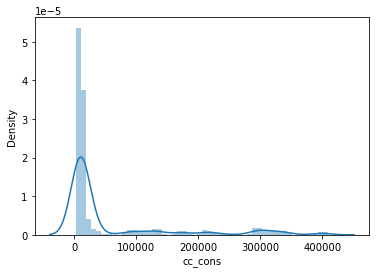

In [24]:
# Ploting distribution of target variable('cc_cons') 

sns.distplot(cust_consumption_existing['cc_cons'])

In [25]:
# Taking log for cc_cons(target variable) variable of the train dataset 

cust_consumption_existing['cc_cons'] = cust_consumption_existing['cc_cons'].apply(lambda x: np.log(x))


<ipython-input-25-8553fccc8eb6>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cust_consumption_existing['cc_cons'] = cust_consumption_existing['cc_cons'].apply(lambda x: np.log(x))


### Feature selection based on importance using F - Regression

In [26]:
# Feature Selection based on importance
from sklearn.feature_selection import f_regression

In [27]:
# splitting the data: separate out the feature/input/independant columns and dependant variable
feature_columns = cust_consumption_existing.columns.difference(['ID', 'cc_cons','ln_cc_cons'])
feature_columns

Index(['Avg_days_between_transaction', 'Emp_Tenure_Years', 'Income_LOW',
       'Income_MEDIUM', 'NetBanking_Flag', 'Tenure_with_Bank',
       'account_type_saving', 'age', 'card_lim', 'cc_cons_apr', 'cc_cons_jun',
       'cc_cons_may', 'cc_count_apr', 'cc_count_jun', 'cc_count_may',
       'credit_amount_apr', 'credit_amount_jun', 'credit_amount_may',
       'credit_count_apr', 'credit_count_jun', 'credit_count_may',
       'dc_cons_apr', 'dc_cons_jun', 'dc_cons_may', 'dc_count_apr',
       'dc_count_jun', 'dc_count_may', 'debit_amount_apr', 'debit_amount_jun',
       'debit_amount_may', 'debit_count_apr', 'debit_count_jun',
       'debit_count_may', 'emi_active', 'gender_M', 'investment_1',
       'investment_2', 'investment_3', 'investment_4', 'max_credit_amount_apr',
       'max_credit_amount_jun', 'max_credit_amount_may',
       'personal_loan_active', 'personal_loan_closed', 'region_code',
       'vehicle_loan_active', 'vehicle_loan_closed'],
      dtype='object')

In [28]:
# seperate the X and y columns
features = cust_consumption_existing[feature_columns]
target = cust_consumption_existing.cc_cons

# do the f_regression
F_values, p_values  = f_regression( features, target )

C:\Users\aksha\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
C:\Users\aksha\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


In [29]:
# combine the output in dataframe
F_regression_op = pd.DataFrame([feature_columns, F_values.round(2), p_values.round(4)]).T

# add the column names
F_regression_op.columns = ['Features', 'F_values', 'p_values' ]
F_regression_op

,Features,F_values,p_values
0,Avg_days_between_transaction,0.63,0.4285
1,Emp_Tenure_Years,2.47,0.1161
2,Income_LOW,0.27,0.6
3,Income_MEDIUM,0.78,0.3767
4,NetBanking_Flag,0.08,0.7817
5,Tenure_with_Bank,0.7,0.4034
6,account_type_saving,0,0.9957
7,age,1.39,0.2377
8,card_lim,0.35,0.5531
9,cc_cons_apr,0.42,0.517


In [30]:
# output of the f_regression
feature_columns = list( F_regression_op.loc[ F_regression_op.p_values <= 0.2, 'Features' ] )

In [31]:
len(feature_columns)

8

In [34]:
print(feature_columns)

['Emp_Tenure_Years', 'cc_cons_jun', 'cc_cons_may', 'cc_count_may', 'credit_amount_jun', 'emi_active', 'investment_3', 'region_code']


### VIF (Variance Inflation Factor): Check the multicollinieirity for all the variables in the model


In [34]:
# import the packages for vif
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices

In [35]:
model_param = 'cc_cons ~ ' + ' + '.join(feature_columns)
model_param

'cc_cons ~ Emp_Tenure_Years + cc_cons_jun + cc_cons_may + cc_count_may + credit_amount_jun + emi_active + investment_3 + region_code'

In [36]:
# separate the Y and X variables
y, X = dmatrices( model_param, cust_consumption_existing, return_type = 'dataframe' )

# For each X, calculate VIF and save in dataframe
vif = pd.DataFrame()

vif['Features'] = X.columns
vif['VIF Factor'] = [ variance_inflation_factor(X.values, i) for i in range(X.shape[1]) ]

# display the output
vif.round(1)

,Features,VIF Factor
0,Intercept,18.6
1,Emp_Tenure_Years,1.0
2,cc_cons_jun,1.0
3,cc_cons_may,1.0
4,cc_count_may,1.0
5,credit_amount_jun,1.0
6,emi_active,1.0
7,investment_3,1.0
8,region_code,1.0


### Split the data for model building

In [37]:
# Divide the data into training and testing
train, test = train_test_split(cust_consumption_existing, test_size = 0.3, random_state = 111)

In [38]:
# verify the no of obs in training and testing after split
print('No of obs in training: ', len(train), ' | ', 'No of obs in testing: ', len(test))

No of obs in training:  10500  |  No of obs in testing:  4500


## Building a Linear regression model¶

In [39]:
m_equation = 'cc_cons ~ ' + ' + '.join( feature_columns )
m_equation

'cc_cons ~ Emp_Tenure_Years + cc_cons_jun + cc_cons_may + cc_count_may + credit_amount_jun + emi_active + investment_3 + region_code'

In [40]:
m_equation = '''cc_cons ~  cc_cons_jun
                + cc_count_may +  investment_3 '''

In [41]:
lm = smf.ols( m_equation, train ).fit()
print( lm.summary() )

                            OLS Regression Results                            
Dep. Variable:                cc_cons   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     3.788
Date:                Wed, 14 Jul 2021   Prob (F-statistic):            0.00993
Time:                        13:46:46   Log-Likelihood:                -18274.
No. Observations:               10500   AIC:                         3.656e+04
Df Residuals:                   10496   BIC:                         3.659e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        9.7382      0.028    349.095   

### Predict the sales on the training and testing data

In [42]:
# training
train.loc[:, 'pred_cons'] = lm.predict(train)

C:\Users\aksha\anaconda3\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\aksha\anaconda3\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [43]:
# testing/validation
test.loc[:, 'pred_cons'] = lm.predict(test)

In [44]:
train[['cc_cons', 'pred_cons']].mean()

cc_cons      9.77677
pred_cons    9.77677
dtype: float64

In [45]:
round(train[['cc_cons', 'pred_cons']],1).head()

,cc_cons,pred_cons
5434,9.5,9.8
5049,9.9,9.8
9513,9.8,9.8
10577,9.8,9.7
3412,9.4,9.7


#### Root Mean Square Percentage Error

In [46]:
RMSPE_train = np.sqrt(np.mean(np.square((train.cc_cons - train.pred_cons) / train.cc_cons)))*100
RMSPE_test = np.sqrt(np.mean(np.square((test.cc_cons - test.pred_cons) / test.cc_cons)))*100

print('RMSPE of training data: ', RMSPE_train,  ' | ', 'RMSPE of testing data: ', RMSPE_test)

RMSPE of training data:  13.131026054682913  |  RMSPE of testing data:  13.084687635960673


## Machine Learning

In [48]:
#Spliting the data in train_x, test_x, train_y, test_y
train_x, test_x, train_y, test_y = train_test_split(cust_consumption_existing[feature_columns],cust_consumption_existing.cc_cons, test_size=0.3, random_state=111)

### Decision tree :

In [51]:
#Importing packages
from sklearn import metrics
from sklearn.tree import DecisionTreeRegressor, export_graphviz, export
from sklearn.model_selection import GridSearchCV

In [71]:
#Model building
param_grid = {'max_depth': np.arange(2, 5),
             'max_features': np.arange(4,7)}
data_tree = GridSearchCV(DecisionTreeRegressor(), param_grid, cv = 3, n_jobs=-1,verbose=1)
data_tree.fit(train_x,train_y)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:    0.1s finished


GridSearchCV(cv=3, estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'max_depth': array([2, 3, 4]),
                         'max_features': array([4, 5, 6])},
             verbose=1)

In [72]:
#Predicting values for both training and testing data sets
tree_train_pred= data_tree.predict(train_x)
tree_test_pred=data_tree.predict(test_x)

In [73]:
#Root Mean Square Percentage Error

RMSPE_train = np.sqrt(np.mean(np.square((train_y - tree_train_pred) / train_y)))*100
RMSPE_test = np.sqrt(np.mean(np.square((test_y- tree_test_pred) / test_y)))*100

print('RMSPE of training data: ', RMSPE_train,  ' | ', 'RMSPE of testing data: ', RMSPE_test)

RMSPE of training data:  13.119173631704204  |  RMSPE of testing data:  13.091621729061357


 ### Ensemble Learining - Random Forest :

In [74]:
#Importing required packages
from sklearn.ensemble import RandomForestRegressor

In [75]:
pargrid_ada = {'n_estimators': [50,60,70,80,100],
               'max_depth':[2,3,4]}

data_rf = GridSearchCV(estimator=RandomForestRegressor(), 
                        param_grid=pargrid_ada, 
                        cv=3,n_jobs=-1, verbose=1)
data_rf.fit(train_x,train_y)

Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    2.7s finished


GridSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [2, 3, 4],
                         'n_estimators': [50, 60, 70, 80, 100]},
             verbose=1)

In [76]:
#Predicting values for both training and testing data sets
rf_train_pred=data_rf.predict(train_x)
rf_test_pred=data_rf.predict(test_x)

In [77]:
#Root Mean Square Percentage Error

RMSPE_train = np.sqrt(np.mean(np.square((train_y - rf_train_pred) / train_y)))*100
RMSPE_test = np.sqrt(np.mean(np.square((test_y- rf_test_pred) / test_y)))*100

print('RMSPE of training data: ', RMSPE_train,  ' | ', 'RMSPE of testing data: ', RMSPE_test)

RMSPE of training data:  13.102857225599632  |  RMSPE of testing data:  13.070417536252565


## Boosting - xgboost :

In [78]:
#Importing Required packages
import xgboost

In [79]:
pargrid_xg = {'n_estimators': [60,70,80,100,120],
               'max_depth':[2,3,4,5]}

gscv_xg = GridSearchCV(estimator=xgboost.XGBRegressor(), 
                        param_grid=pargrid_xg, 
                        cv=3,n_jobs=-1 , verbose=1)

data_xg=gscv_xg.fit(train_x, train_y)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    3.4s finished


In [80]:
#Predicting values for both training and testing data sets
xg_train_pred=data_xg.predict(train_x)
xg_test_pred=data_xg.predict(test_x)

In [81]:
#Root Mean Square Percentage Error

RMSPE_train = np.sqrt(np.mean(np.square((train_y - xg_train_pred) / train_y)))*100
RMSPE_test = np.sqrt(np.mean(np.square((test_y- xg_test_pred) / test_y)))*100

print('RMSPE of training data: ', RMSPE_train,  ' | ', 'RMSPE of testing data: ', RMSPE_test)

RMSPE of training data:  12.900633495433162  |  RMSPE of testing data:  13.07331656634052


### Prediction on New data by Random Forest Regressor

In [97]:
cust_consumption_new2 = cust_consumption_new[feature_columns]

In [99]:
cust_consumption_new2.loc[:,'cc_cons'] = data_rf.predict(cust_consumption_new2)

C:\Users\aksha\anaconda3\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\aksha\anaconda3\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [100]:
cust_consumption_new2['cc_cons'] = round(np.exp(cust_consumption_new2['cc_cons']),1)

<ipython-input-100-9d3f2ad58401>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cust_consumption_new2['cc_cons'] = round(np.exp(cust_consumption_new2['cc_cons']),1)


In [102]:
new_cust_cons = pd.concat([cust_consumption_new.ID, cust_consumption_new2.cc_cons], axis=1)
new_cust_cons

,ID,cc_cons
0,17999,16902.8
1,16150,16965.3
2,11749,17607.7
3,11635,18686.6
4,8908,17780.0
...,...,...
19995,2000,16536.8
19996,15992,17869.3
19997,7081,17462.6
19998,6821,18047.5
